In [1]:
# Pandas
from config import DB_USER, DB_PASS, DB_ENDPOINT
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


# SQL Alchemy
from sqlalchemy import create_engine

In [2]:
 # Create Engine
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_ENDPOINT}")
conn = engine.connect()

In [3]:
# Query All Records in the the Database
data = pd.read_sql("SELECT * FROM historical", conn, index_col="index")
data.head()

,crypto,time,open,high,low,close,volume,trade
index,,,,,,,,
0,bitcoin_usdt,1.511914e+09,9896.79000000,11300.03000000,8520.00000000,9687.88000000,13352.53871500,8662.63236200
1,bitcoin_usdt,1.512000e+09,9687.88000000,10900.00000000,8850.80000000,9838.96000000,9389.57432900,5360.66024200
2,bitcoin_usdt,1.512086e+09,9837.00000000,10898.00000000,9380.00000000,10782.99000000,6134.92363300,3269.86858800
3,bitcoin_usdt,1.512173e+09,10775.04000000,11190.00000000,10620.00000000,10890.01000000,4765.43975700,2390.19427500
4,bitcoin_usdt,1.512259e+09,10902.69000000,11825.00000000,10500.00000000,11165.41000000,5346.63652400,2574.24618700


In [4]:
data.isnull().sum()

crypto    0
time      0
open      0
high      0
low       0
close     0
volume    0
trade     0
dtype: int64

In [5]:
# filter for ethereum and reset the index so the index is numbered correctly
ethereum_df = data[data["crypto"] == "ethereum_usdt"]
ethereum_df = ethereum_df.reset_index(drop=True)
ethereum_df.head()

,crypto,time,open,high,low,close,volume,trade
0,ethereum_usdt,1.511914e+09,466.17000000,515.00000000,385.00000000,421.70000000,51313.49571000,23825.39377000
1,ethereum_usdt,1.512000e+09,421.92000000,460.00000000,387.01000000,427.43000000,45184.22265000,24018.42012000
2,ethereum_usdt,1.512086e+09,428.05000000,465.97000000,413.74000000,457.51000000,33072.21995000,19043.24922000
3,ethereum_usdt,1.512173e+09,457.53000000,471.91000000,445.00000000,457.63000000,25796.14000000,12336.59141000
4,ethereum_usdt,1.512259e+09,457.31000000,485.90000000,440.11000000,460.30000000,24490.05997000,12239.10293000


In [6]:
# drop the crypto column which is just a name
ethereum_df = ethereum_df.drop("crypto", axis=1)
ethereum_df.head()

,time,open,high,low,close,volume,trade
0,1.511914e+09,466.17000000,515.00000000,385.00000000,421.70000000,51313.49571000,23825.39377000
1,1.512000e+09,421.92000000,460.00000000,387.01000000,427.43000000,45184.22265000,24018.42012000
2,1.512086e+09,428.05000000,465.97000000,413.74000000,457.51000000,33072.21995000,19043.24922000
3,1.512173e+09,457.53000000,471.91000000,445.00000000,457.63000000,25796.14000000,12336.59141000
4,1.512259e+09,457.31000000,485.90000000,440.11000000,460.30000000,24490.05997000,12239.10293000


In [7]:
ethereum_df["time"] = pd.to_datetime(ethereum_df['time'], unit="s")
ethereum_df.head()

,time,open,high,low,close,volume,trade
0,2017-11-29,466.17000000,515.00000000,385.00000000,421.70000000,51313.49571000,23825.39377000
1,2017-11-30,421.92000000,460.00000000,387.01000000,427.43000000,45184.22265000,24018.42012000
2,2017-12-01,428.05000000,465.97000000,413.74000000,457.51000000,33072.21995000,19043.24922000
3,2017-12-02,457.53000000,471.91000000,445.00000000,457.63000000,25796.14000000,12336.59141000
4,2017-12-03,457.31000000,485.90000000,440.11000000,460.30000000,24490.05997000,12239.10293000


In [8]:
ethereum_df = ethereum_df.set_index("time")
ethereum_df.head()

,open,high,low,close,volume,trade
time,,,,,,
2017-11-29,466.17000000,515.00000000,385.00000000,421.70000000,51313.49571000,23825.39377000
2017-11-30,421.92000000,460.00000000,387.01000000,427.43000000,45184.22265000,24018.42012000
2017-12-01,428.05000000,465.97000000,413.74000000,457.51000000,33072.21995000,19043.24922000
2017-12-02,457.53000000,471.91000000,445.00000000,457.63000000,25796.14000000,12336.59141000
2017-12-03,457.31000000,485.90000000,440.11000000,460.30000000,24490.05997000,12239.10293000


In [9]:
ethereum_df.dtypes

open      object
high      object
low       object
close     object
volume    object
trade     object
dtype: object

In [10]:
# convert to numerical
ethereum_df = ethereum_df.astype({"open": float, "high": float, "low":float, "close": float, "volume": float, "trade": float})
ethereum_df.dtypes

open      float64
high      float64
low       float64
close     float64
volume    float64
trade     float64
dtype: object

In [11]:
# Set data features
X = ethereum_df.drop("close", axis=1)
X

,open,high,low,volume,trade
time,,,,,
2017-11-29,466.17,515.00,385.00,51313.49571,23825.39377
2017-11-30,421.92,460.00,387.01,45184.22265,24018.42012
2017-12-01,428.05,465.97,413.74,33072.21995,19043.24922
2017-12-02,457.53,471.91,445.00,25796.14000,12336.59141
2017-12-03,457.31,485.90,440.11,24490.05997,12239.10293
...,...,...,...,...,...
2021-11-25,4270.10,4550.00,4248.27,445868.24340,231824.31930
2021-11-26,4524.48,4551.00,3913.00,720245.16120,348872.86610
2021-11-27,4041.20,4183.66,4028.34,275326.52020,136157.34820


In [12]:
# Set data target
y = ethereum_df[["close"]]
y

,close
time,
2017-11-29,421.70
2017-11-30,427.43
2017-12-01,457.51
2017-12-02,457.63
2017-12-03,460.30
...,...
2021-11-25,4524.85
2021-11-26,4041.20
2021-11-27,4095.29


As our data is time-dependent, we need to use times series split for validation.\
I have set n_splits = 3.
As we have 4 years of data it will split like this:
* 1st split:  TRAIN: Year 1, TEST: Year 2
* 2nd split:  TRAIN: Year 1 to end of Year 2. TEST: Year 3
* 3rd split:  TRAIN: Year 1 to end of Year 3. TEST: Year 4

LR: 0.996457 (0.000625)
Lasso: 0.893547 (0.071087)
Ridge: 0.114476 (0.743009)
RF: 0.306645 (0.962730)
XGBOOST: 0.261323 (1.008291)
NN: 0.991058 (0.004061)
KNN: -8.056331 (7.945834)
SVR: -11.697607 (13.602726)


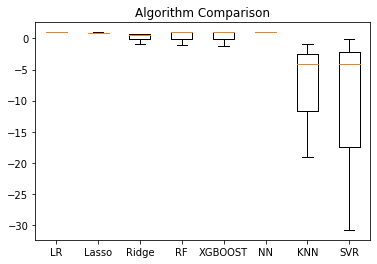

In [13]:
# perform cross validation for different models to see which model will be suitable.
# As this is is time-series data, train test split will not be used, and time series split will be used instead.
import warnings
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score


warnings.simplefilter("ignore")

models = []
models.append(('LR', LinearRegression(normalize=True)))
models.append(('Lasso', Lasso(normalize=True))) 
models.append(('Ridge', Ridge(normalize=True))) 
models.append(('RF', RandomForestRegressor(n_estimators = 200)))
models.append(('XGBOOST', XGBRegressor(n_estimators = 200, verbosity = 0)))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR(gamma='auto')))

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    tscv = TimeSeriesSplit(n_splits=3)
    cv_results = cross_val_score(model, X, y, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [14]:
# check dataframe date range for splitting into train and test
ethereum_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2017-11-29 to 2021-11-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1462 non-null   float64
 1   high    1462 non-null   float64
 2   low     1462 non-null   float64
 3   close   1462 non-null   float64
 4   volume  1462 non-null   float64
 5   trade   1462 non-null   float64
dtypes: float64(6)
memory usage: 80.0 KB


In [15]:
# now want to reset the train and test data to fit the model and test.

#set train data to be everything except the last month.
train = ethereum_df.loc["2017-11": "2021-10"]

#keep the last 2 months for the test data
test = ethereum_df.loc["2021-11"]

In [16]:
train

,open,high,low,close,volume,trade
time,,,,,,
2017-11-29,466.17,515.00,385.00,421.70,51313.49571,23825.39377
2017-11-30,421.92,460.00,387.01,427.43,45184.22265,24018.42012
2017-12-01,428.05,465.97,413.74,457.51,33072.21995,19043.24922
2017-12-02,457.53,471.91,445.00,457.63,25796.14000,12336.59141
2017-12-03,457.31,485.90,440.11,460.30,24490.05997,12239.10293
...,...,...,...,...,...,...
2021-10-27,4131.52,4307.00,3909.00,3922.00,704604.25000,342946.25220
2021-10-28,3921.99,4295.00,3890.17,4286.02,626378.50550,331721.67970
2021-10-29,4286.01,4460.47,4265.97,4418.89,559231.07691,299827.57771


In [17]:
test

,open,high,low,close,volume,trade
time,,,,,,
2021-11-01,4287.48,4386.58,4146.30,4319.43,417620.70730,208433.93650
2021-11-02,4319.43,4599.60,4284.43,4589.89,468184.79301,245450.71120
2021-11-03,4589.68,4665.87,4455.00,4603.35,448658.35125,221693.79026
2021-11-04,4603.35,4606.65,4420.08,4532.32,368218.25695,180789.48190
2021-11-05,4532.31,4570.05,4438.80,4474.24,305651.72440,152155.85650
2021-11-06,4474.24,4530.00,4326.17,4518.00,322154.09730,162175.62780
2021-11-07,4518.00,4637.98,4502.37,4612.59,243596.59520,124167.19250
2021-11-08,4612.59,4822.97,4612.00,4807.98,391102.31806,202324.49531
2021-11-09,4807.98,4838.28,4713.89,4732.33,311267.57998,147968.47588


In [18]:
# Assign our train and test dataframes to X_train, y_train, X_test, y_test variables
X_train, y_train = train.drop("close", axis=1), train[["close"]]
X_test, y_test =  test.drop("close", axis=1), test[["close"]]

In [19]:
X_train

,open,high,low,volume,trade
time,,,,,
2017-11-29,466.17,515.00,385.00,51313.49571,23825.39377
2017-11-30,421.92,460.00,387.01,45184.22265,24018.42012
2017-12-01,428.05,465.97,413.74,33072.21995,19043.24922
2017-12-02,457.53,471.91,445.00,25796.14000,12336.59141
2017-12-03,457.31,485.90,440.11,24490.05997,12239.10293
...,...,...,...,...,...
2021-10-27,4131.52,4307.00,3909.00,704604.25000,342946.25220
2021-10-28,3921.99,4295.00,3890.17,626378.50550,331721.67970
2021-10-29,4286.01,4460.47,4265.97,559231.07691,299827.57771


In [20]:
y_train

,close
time,
2017-11-29,421.70
2017-11-30,427.43
2017-12-01,457.51
2017-12-02,457.63
2017-12-03,460.30
...,...
2021-10-27,3922.00
2021-10-28,4286.02
2021-10-29,4418.89


In [21]:
# Create model
model = LinearRegression()

In [22]:
# Scale the data
X_scaler = StandardScaler()
X_scaler.fit(X_train)

StandardScaler()

In [23]:
# Apply the StandardScaler to the train and test datasets
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [24]:
# Train the model
model.fit(X_train_scaled, y_train)

LinearRegression()

In [25]:
#print R2 score
model_score = model.score(X_test_scaled, y_test)

print(f"Model R2 Score: {model_score}")

Model R2 Score: 0.9194767095962151


In [26]:
# Let's see how well it performs on the test data
pred = model.predict(X_test_scaled)
pred

array([[4267.22020601],
       [4532.83479955],
       [4550.94635275],
       [4467.47157574],
       [4485.33999529],
       [4409.64962113],
       [4595.50081143],
       [4782.17266323],
       [4751.15802834],
       [4660.00733678],
       [4710.78404684],
       [4645.52962412],
       [4631.2228369 ],
       [4586.30060371],
       [4682.6339195 ],
       [4247.58306141],
       [4177.48025358],
       [4105.44769043],
       [4247.56713396],
       [4342.30760837],
       [4317.29056163],
       [4142.55508297],
       [4322.29820434],
       [4241.08627629],
       [4491.3006    ],
       [4137.28577991],
       [4142.30720645],
       [4176.70510437],
       [4410.43206746]])

In [27]:
data = pd.DataFrame()
data["actual"] = y_test
data["predicted"] = pred
data["difference(%)"] = (data["predicted"]-data["actual"]) / data["actual"]*100
data

,actual,predicted,difference(%)
time,,,
2021-11-01,4319.43,4267.220206,-1.208720
2021-11-02,4589.89,4532.834800,-1.243062
2021-11-03,4603.35,4550.946353,-1.138381
2021-11-04,4532.32,4467.471576,-1.430800
2021-11-05,4474.24,4485.339995,0.248087
2021-11-06,4518.00,4409.649621,-2.398193
2021-11-07,4612.59,4595.500811,-0.370490
2021-11-08,4807.98,4782.172663,-0.536760
2021-11-09,4732.33,4751.158028,0.397860


In [28]:
print(data["difference(%)"].mean())

-0.23493944392079594


<AxesSubplot:xlabel='time'>

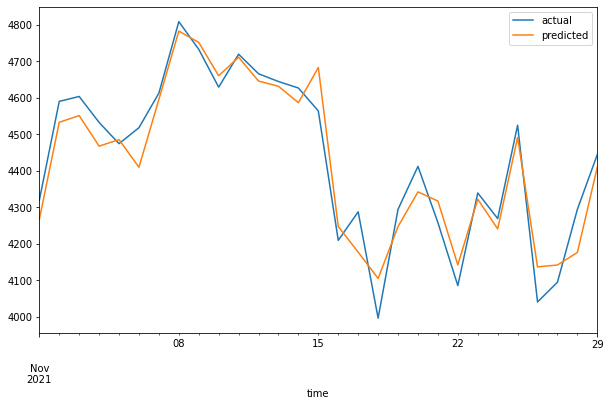

In [29]:
data.plot(y=["actual","predicted"], figsize=(10,6))

In [30]:
data = pd.DataFrame()
data["features"] = X_train.columns.tolist()
data["scores"] = model.coef_[0]
data

,features,scores
0,open,-534.009415
1,high,924.387106
2,low,594.625973
3,volume,-53.363701
4,trade,53.583753


<AxesSubplot:xlabel='features'>

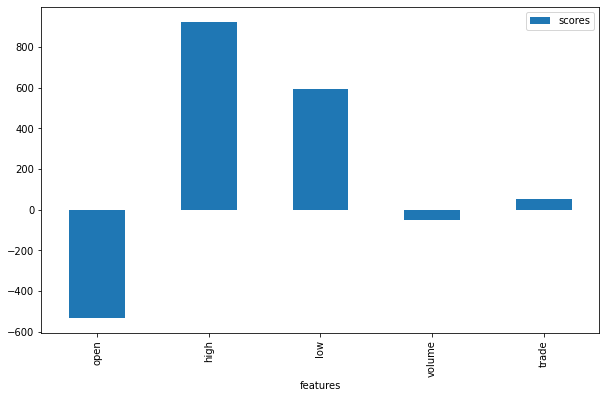

In [32]:
data.plot(kind="bar", x="features", y="scores", figsize=(10,6)) 

All the features seem to be contributing to the close price. 